In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

In [2]:
compression_id = "7gag0n2o"

In [3]:
import warnings
warnings.filterwarnings('ignore')

cath_id = "1jzdC00"
pdb_path = f"/data/lux70/data/cath/dompdb/{cath_id}"

from plaid.utils import parse_sequence_from_structure

with open(pdb_path) as f:
    pdb_str = f.read()
    
orig_sequence = parse_sequence_from_structure(pdb_str, cath_id)
print(orig_sequence)

from plaid.utils import view_py3Dmol
view_py3Dmol(pdb_str)

RSQFVPADQAFAFDFQQNQHDLNLTWQIKDGYYLYRKQIRITPEHAKIADVQLPQGVWHEDEFYGKSEIYRDRLTLPVTINQASAGATLTVTYQGAADAGFCYPPETKTVPLSEVVAN


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
from plaid.esmfold import esmfold_v1
import torch

device = torch.device("cuda:0")
esmfold = esmfold_v1()
_ = esmfold.to(device)

from plaid.compression import HourglassVQLightningModule

ckpt_path = Path(f"/data/lux70/cheap/checkpoints/{compression_id}/") / "last.ckpt"
hourglass = HourglassVQLightningModule.load_from_checkpoint(ckpt_path)

from cheap.proteins import LatentToSequence, LatentToStructure

latent_to_sequence = LatentToSequence()
latent_to_sequence.to(device)

latent_to_structure = LatentToStructure(esmfold=esmfold, delete_esm_lm=False)
latent_to_structure.to(device)

from plaid.utils import LatentScaler
scaler = LatentScaler()

Creating ESMFold...
ESMFold model loaded in 39.28 seconds.
Init hourglass model on rank 0
using quantizer fsq
Codebook size: tensor(65536)


In [6]:
res = esmfold.infer_embedding(orig_sequence)
x = res['s']
mask = res['mask']
x = x.to(device)
mask = mask.to(device)
print(x.shape)

x_norm = scaler.scale(x)
print(x_norm.shape)

x_recons, loss, log_dict, x_compressed, downsampled_mask = hourglass(x_norm, mask.bool(), log_wandb=False, infer_only=False)
x_compressed.shape

torch.Size([1, 118, 1024])
torch.Size([1, 118, 1024])


torch.Size([1, 118])

In [7]:
z_q = hourglass.quantizer.indexes_to_codes(x_compressed)
print(z_q.shape)

torch.Size([1, 118, 4])


<Axes: >

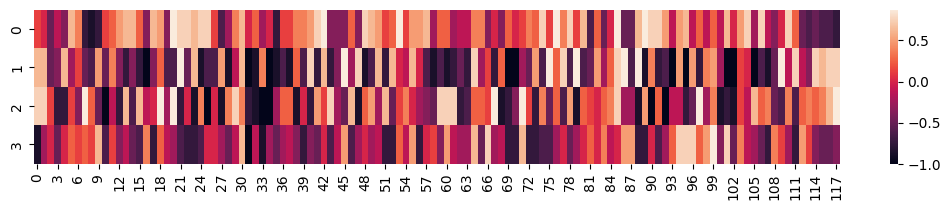

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(13,2))
sns.heatmap(z_q.T.squeeze().detach().cpu().numpy(), ax=ax)

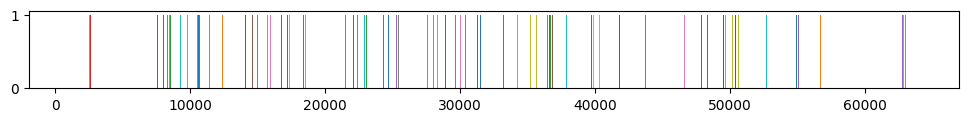

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(12,1))
_ = plt.hist(x_compressed.detach().cpu().numpy())

In [84]:
hourglass.quantizer.codebook_size

tensor(65536)

In [91]:
from sklearn.preprocessing import OneHotEncoder
ohe = torch.zeros((1, hourglass.quantizer.codebook_size.item()))
ohe[0, x_compressed.detach().cpu()] = 1

In [96]:
ohe.max()

tensor(1.)

<Axes: >

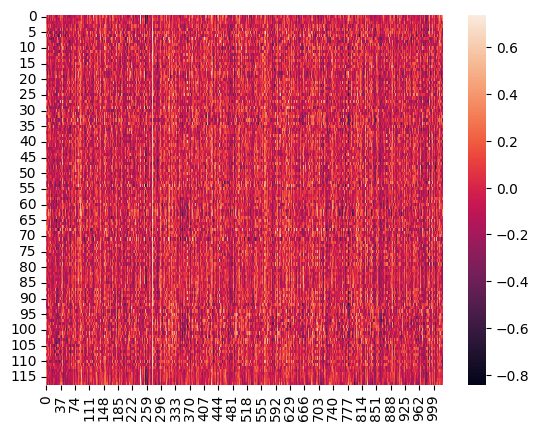

In [10]:
sns.heatmap(x_recons.squeeze().detach().cpu().numpy())

In [11]:
from plaid.utils import LatentScaler

latent_scaler = LatentScaler()
x_recons = latent_scaler.unscale(x_recons)

recons_sequence = latent_to_sequence.to_sequence(x_recons)[-1]

recons_struct = latent_to_structure.to_structure(x_recons, recons_sequence, return_raw_features=True, batch_size=4, num_recycles=4)
pred_struct = latent_to_structure.to_structure(x, recons_sequence, return_raw_features=True, batch_size=4, num_recycles=4)

(Generating structure): 100%|███████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


In [57]:
outdir = Path("/data/lux70/plaid/artifacts/mask_tokens")
recons_pdb_path = outdir / "recons_struct.pdb"
pred_pdb_path = outdir / "pred_struct.pdb"


with open(recons_pdb_path, "w") as f:
    f.write(recons_struct[0])

with open(pred_pdb_path, "w") as f:
    f.write(pred_struct[0])

In [18]:
from plaid.utils import pdb_path_to_biotite_atom_array

recons_atom_array = pdb_path_to_biotite_atom_array(recons_pdb_path)[0]
pred_atom_array = pdb_path_to_biotite_atom_array(pred_pdb_path)[0]
orig_atom_array = pdb_path_to_biotite_atom_array(pdb_path)[0]

In [22]:
from biotite import structure

recons_superimposed = structure.superimpose(pred_atom_array, recons_atom_array)

In [24]:
from plaid.evaluation import run_tmalign
tm_score = run_tmalign(pdb_path, pred_pdb_path)
tm_score

0.94519

In [25]:
from plaid.evaluation import run_tmalign
tm_score = run_tmalign(pdb_path, recons_pdb_path)
tm_score

0.95766

In [51]:
tm_score = run_tmalign(recons_pdb_path, pred_pdb_path)
tm_score

0.92808

In [102]:
from plaid.utils import view_py3Dmol
import py3Dmol

view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(pred_struct[0])
view.addModelsAsFrames(recons_struct[0])

# view.addModelsAsFrames(pdb_str)
view.setStyle({"model": 0}, {"cartoon": {"color": "#F6DDCC"}})
view.setStyle({"model": 1}, {"cartoon": {"color": "#FF9800"}})
# view.setStyle({"model": 2}, {"cartoon": {"color": "green"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# col 0

In [108]:
z_q_0 = z_q.clone()
z_q_0[:, :, 0] *= 0

<Axes: >

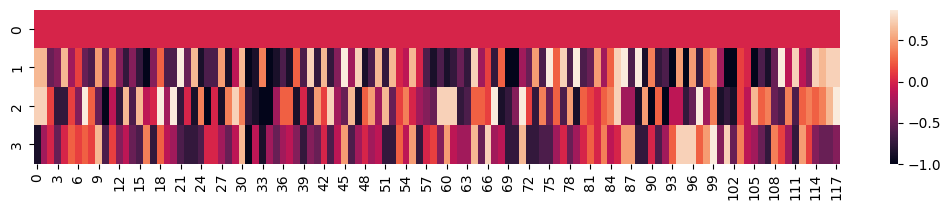

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(13,2))
sns.heatmap(z_q_0.T.squeeze().detach().cpu().numpy(), ax=ax)

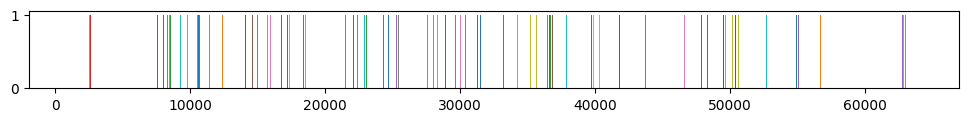

In [110]:
idx0 = hourglass.quantizer.codes_to_indexes(z_q_0)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(12,1))
_ = plt.hist(idx0.detach().cpu().numpy())

In [111]:
recons_z_q_0 = hourglass.dec(hourglass.post_quant_proj(z_q_0))
recons_z_q_0 = latent_scaler.unscale(recons_z_q_0)
recons_zq0_sequences = latent_to_sequence.to_sequence(recons_z_q_0)[-1]
recons_zq0_structure = latent_to_structure.to_structure(recons_z_q_0, recons_zq0_sequences)

In [112]:
from plaid.utils import view_py3Dmol
import py3Dmol

view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(pred_struct[0])
view.addModelsAsFrames(recons_zq0_structure[0][0])

view.setStyle({"model": 0}, {"cartoon": {"color": "#F6DDCC"}})
view.setStyle({"model": 1}, {"cartoon": {"color": "#FF9800"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [113]:
recons_zq0_fpath = outdir / "recons_struct_zq0.pdb"

with open(recons_zq0_fpath, "w") as f:
    f.write(recons_zq0_structure[0][0])

In [114]:
tm_score = run_tmalign(recons_zq0_fpath, pred_pdb_path)
tm_score

0.92808

# col 1

In [60]:
z_q_1 = z_q.clone()
z_q_1[:, :, 1] *= 0

recons_z_q_1 = hourglass.dec(hourglass.post_quant_proj(z_q_1))
recons_z_q_1 = latent_scaler.unscale(recons_z_q_1)
recons_zq1_sequences = latent_to_sequence.to_sequence(recons_z_q_1)[-1]
recons_zq1_structure = latent_to_structure.to_structure(recons_z_q_1, recons_zq1_sequences)


<Axes: >

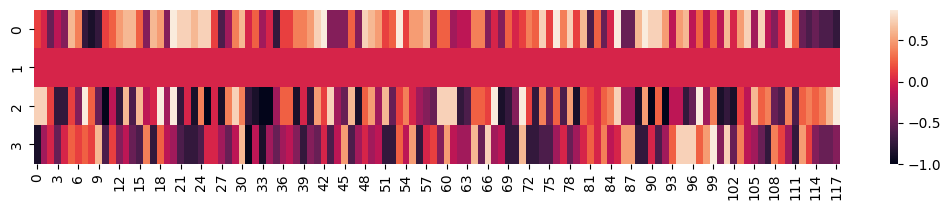

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(13,2))
sns.heatmap(z_q_1.T.squeeze().detach().cpu().numpy(), ax=ax)

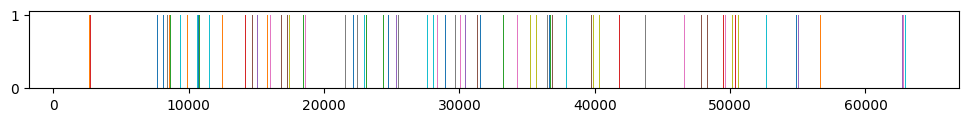

In [98]:
idx1 = hourglass.quantizer.codes_to_indexes(z_q_1)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(12,1))
_ = plt.hist(idx1.detach().cpu().numpy())

In [104]:
from plaid.utils import view_py3Dmol
import py3Dmol

view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(pred_struct[0])
view.addModelsAsFrames(recons_zq1_structure[0][0])

view.setStyle({"model": 0}, {"cartoon": {"color": "#F6DDCC"}})
view.setStyle({"model": 1}, {"cartoon": {"color": "#FF9800"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [63]:
recons_zq1_fpath = outdir / "recons_struct_zq1.pdb"

with open(recons_zq1_fpath, "w") as f:
    f.write(recons_zq1_structure[0][0])

tm_score = run_tmalign(recons_zq1_fpath, pred_pdb_path)
tm_score

0.38666

# col 2

In [ ]:
z_q_2 = z_q.clone()
z_q_2[:, :, 2] *= 0

recons_z_q_2 = hourglass.dec(hourglass.post_quant_proj(z_q_2))
recons_z_q_2 = latent_scaler.unscale(recons_z_q_2)
recons_zq2_sequences = latent_to_sequence.to_sequence(recons_z_q_2)[-1]
recons_zq2_structure = latent_to_structure.to_structure(recons_z_q_2, recons_zq2_sequences)


recons_zq2_fpath = outdir / "recons_struct_zq2.pdb"

with open(recons_zq2_fpath, "w") as f:
    f.write(recons_zq2_structure[0][0])

tm_score = run_tmalign(recons_zq2_fpath, pred_pdb_path)
print(tm_score)

<Axes: >

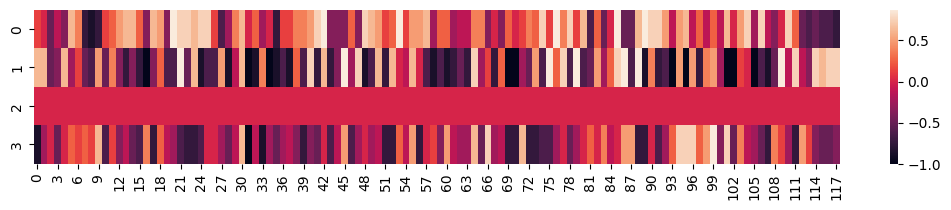

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(13,2))
sns.heatmap(z_q_2.T.squeeze().detach().cpu().numpy(), ax=ax)

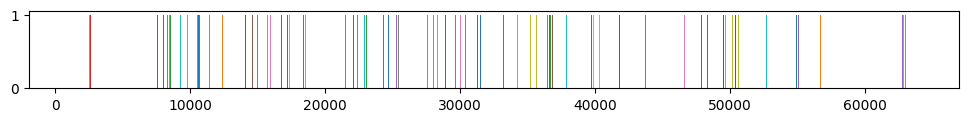

In [100]:
idx2 = hourglass.quantizer.codes_to_indexes(z_q_2)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(12,1))
_ = plt.hist(idx0.detach().cpu().numpy())

In [106]:

from plaid.utils import view_py3Dmol
import py3Dmol

view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(pred_struct[0])
view.addModelsAsFrames(recons_zq2_structure[0][0])

view.setStyle({"model": 0}, {"cartoon": {"color": "#F6DDCC"}})
view.setStyle({"model": 1}, {"cartoon": {"color": "#FF9800"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [115]:
tm_score = run_tmalign(recons_zq2_fpath, pred_pdb_path)
tm_score

0.34142

# col 3

In [107]:
z_q_3 = z_q.clone()
z_q_3[:, :, 3] *= 0

recons_z_q_3 = hourglass.dec(hourglass.post_quant_proj(z_q_3))
recons_z_q_3 = latent_scaler.unscale(recons_z_q_3)
recons_zq3_sequences = latent_to_sequence.to_sequence(recons_z_q_3)[-1]
recons_zq3_structure = latent_to_structure.to_structure(recons_z_q_3, recons_zq3_sequences)


recons_zq3_fpath = outdir / "recons_struct_zq3.pdb"

with open(recons_zq3_fpath, "w") as f:
    f.write(recons_zq3_structure[0][0])

tm_score = run_tmalign(recons_zq3_fpath, pred_pdb_path)
print(tm_score)



from plaid.utils import view_py3Dmol
import py3Dmol

view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(pred_struct[0])
view.addModelsAsFrames(recons_zq3_structure[0][0])

view.setStyle({"model": 0}, {"cartoon": {"color": "#F6DDCC"}})
view.setStyle({"model": 1}, {"cartoon": {"color": "#FF9800"}})
view.zoomTo()
view.show()

0.36674


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<Axes: >

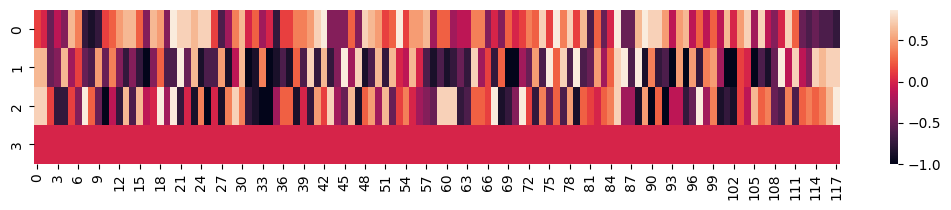

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(13,2))
sns.heatmap(z_q_3.T.squeeze().detach().cpu().numpy(), ax=ax)

In [ ]:
tm_score = run_tmalign(recons_zq2_fpath, pred_pdb_path)
tm_score